In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.15.0

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installatio

In [3]:
import pandas as pd

processed_df = pd.read_csv('/content/drive/MyDrive/Project1119/data_processed.csv')
processed_df.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,NaN
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,NaN
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,NaN
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,NaN
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,NaN


In [4]:
processed_df['TX_INTERVAL'].fillna(0, inplace=True)

<ipython-input-4-1a36b316b5fe>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['TX_INTERVAL'].fillna(0, inplace=True)


In [5]:
processed_df_drop = processed_df.dropna()

In [6]:
processed_df_drop.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,0.0
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,0.0
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,0.0
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,0.0
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,0.0


In [7]:
from sklearn.preprocessing import StandardScaler

df_copy = processed_df_drop.copy()

scaler = StandardScaler()
df_copy['TX_AMT'] = scaler.fit_transform(df_copy[['TX_AMT']])

df_copy['TX_TIME'] = pd.to_datetime(df_copy['TX_DTTM']).dt.hour + pd.to_datetime(df_copy['TX_DTTM']).dt.minute / 60

In [8]:
cleaned_df = df_copy[['MBR_NO', 'TX_TIME','TX_AMT', 'TX_TYPE', 'BIS_NM', 'REGULAR_YN', 'TX_INTERVAL']].copy()

cleaned_df.head()

,MBR_NO,TX_TIME,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,23.500000,-8.849636,2,0,0,0.0
1,1303,19.250000,-8.821235,2,0,0,0.0
2,1349,16.300000,-6.208327,2,0,0,0.0
3,1349,0.500000,-4.742732,2,0,0,0.0
4,1303,5.333333,-0.237293,0,0,0,0.0


In [9]:
print(cleaned_df['REGULAR_YN'].value_counts())


REGULAR_YN
0    2500973
1       2060
Name: count, dtype: int64


### 불균형 확인

In [10]:
cleaned_df['REGULAR_YN'].value_counts()


,count
REGULAR_YN,
0,2500973
1,2060


In [11]:
import numpy as np

features = cleaned_df.values
labels = np.array(cleaned_df.pop('REGULAR_YN'))

print(features.shape)
print(labels.shape)

(2503033, 7)
(2503033,)


In [12]:
from sklearn.model_selection import train_test_split


# 훈련/임시 테스트 데이터 나누기
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)

# 임시 테스트 데이터를 테스트/검증으로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"훈련 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}, 테스트 데이터 크기: {X_test.shape}")



훈련 데이터 크기: (1251516, 7), 검증 데이터 크기: (625758, 7), 테스트 데이터 크기: (625759, 7)


In [13]:
from collections import Counter

print(Counter(labels))
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))




Counter({0: 2500973, 1: 2060})
Counter({0: 1250486, 1: 1030})
Counter({0: 625243, 1: 515})
Counter({0: 625244, 1: 515})


In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### 정상거래로만 오토인코더 학습

In [15]:
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]
print(X_train_normal.shape, X_train_fraud.shape)

(1250486, 7) (1030, 7)


In [16]:
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]
print(X_test_normal.shape, X_test_fraud.shape)


(625244, 7) (515, 7)


### 데이터 파이프라인 작성

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices(X_train_normal).shuffle(10000).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices(X_test_normal).batch(128)

In [18]:
print(type(train_ds), type(test_ds))


<class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


### Sampling Class 빌드

In [19]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """인코더의 출력과 결합하여 무작위 샘플을 생성합니다.
        Args:
          inputs -- 인코더로부터의 출력 텐서 (평균 mu, 표준편차 sigma)
        Returns:
          무작위 샘플이 결합된 `inputs` 텐서
        """
        # 인코더의 출력을 분해합니다.
        mu, sigma = inputs

        # 배치의 크기와 차원을 얻습니다.
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # 무작위 텐서를 생성합니다.
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # 재매개변수화 기법을 적용합니다.
        return mu + tf.math.exp(0.5 * sigma) * epsilon

In [20]:
# from tensorflow.keras import backend as K

# def kl_reconstruction_loss(mu, sigma):
#     """Kullback-Leibler Divergence 손실"""
#     kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
#     return K.mean(kl_loss) * -0.5


In [21]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """Kullback-Leibler 발산(KLD) 계산
    Args:
    inputs -- 데이터셋 배치
    outputs -- Sampling 층의 출력
    mu -- 평균
    sigma -- 표준 편차

    Returns:
    KLD 손실
    """
    # KLD 계산 공식 적용
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    # 배치 내 평균을 계산하고 -0.5를 곱하여 최종 KLD 손실을 계산
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss



In [22]:
# @tf.function
# def kl_reconstruction_loss(mu, sigma):
#     """Kullback-Leibler 발산(KLD) 계산"""
#     kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
#     kl_loss = tf.reduce_mean(kl_loss) * -0.5
#     return kl_loss

# # VAE 모델 정의
# vae_input = encoder_input
# mu, sigma, z = encoder(vae_input)
# reconstructed = decoder(z)

# vae = Model(vae_input, reconstructed)

# # 사용자 정의 손실 추가
# vae.add_loss(kl_reconstruction_loss(mu, sigma))
# vae.add_loss(tf.reduce_mean(tf.keras.losses.mse(vae_input, reconstructed)))

# # 모델 컴파일
# vae.compile(optimizer='adam')

# # 모델 학습
# history = vae.fit(train_ds, validation_data=test_ds, epochs=50)

# # 테스트 데이터 재구성
# reconstructed_test = vae.predict(X_test_normal)

# # 재구성 오류 계산
# reconstruction_error = np.mean(np.square(X_test_normal - reconstructed_test), axis=1)
# print("Reconstruction error:", reconstruction_error)


In [23]:
# def kl_reconstruction_loss(mu, sigma):
#     """Kullback-Leibler 발산(KLD) 계산"""
#     kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
#     kl_loss = tf.reduce_mean(kl_loss) * -0.5
#     return kl_loss


# # VAE 모델 정의
# vae_input = encoder_input
# mu, sigma, z = encoder(vae_input)
# reconstructed = decoder(z)

# vae = Model(vae_input, reconstructed)

# # 사용자 정의 손실 추가
# vae.add_loss(kl_reconstruction_loss(mu, sigma))
# vae.add_loss(tf.reduce_mean(tf.keras.losses.mse(vae_input, reconstructed)))

# # 모델 컴파일
# vae.compile(optimizer='adam')

# # 모델 학습
# history = vae.fit(train_ds, validation_data=test_ds, epochs=50)



# # 테스트 데이터 재구성
# reconstructed_test = vae.predict(X_test_normal)

# # 재구성 오류 계산
# reconstruction_error = tf.reduce_mean(tf.square(X_test_normal - reconstructed_test), axis=1)
# print("Reconstruction error:", reconstruction_error.numpy())


In [24]:
# 잠재 공간의 차원을 2로 설정합니다. 즉, 인코더는 입력 데이터를 2차원의 잠재 벡터로 압축합니다.
LATENT_DIM = 2

# X_train_normal 데이터셋의 특징(피처) 수를 입력 데이터의 차원으로 설정합니다.
input_dim = X_train_normal.shape[-1]

In [25]:
# 인코더의 입력 레이어를 정의
encoder_input = Input(shape=(input_dim,))
# 은닉층을 정의합니다.
x = Dense(32, activation='relu')(encoder_input)
x = Dense(16, activation='relu')(x)

# 잠재 변수의 평균을 나타내는 mu 레이어 정의
mu = Dense(LATENT_DIM)(x)

# 잠재 변수의 표준 편차를 나타내는 sigma 레이어 정의
sigma = Dense(LATENT_DIM)(x)

# 샘플링 레이어를 통해 잠재 벡터 z를 샘플링합니다.
z = Sampling()((mu, sigma))  # mu와 sigma를 사용하여 잠재 공간 z에서 샘플링합니다.

# 인코더 모델을 정의합니다.
encoder = Model(encoder_input, [mu, sigma, z])

In [26]:
# 디코더의 입력 레이어를 정의합니다.
decoder_input = Input(shape=(LATENT_DIM,))

# 은닉층을 정의
x = Dense(16, activation='relu')(decoder_input)
x = Dense(32, activation='relu')(x)

# 출력층을 정의. 원래 입력 데이터 차원으로 복원
decoded = Dense(input_dim)(x)

# 디코더 모델을 정의
decoder = Model(decoder_input, decoded)

In [27]:
!pip install tensorflow==2.15.0

vae_input = encoder_input

# 인코더를 통과시켜 평균(mu), 표준 편차(sigma), 그리고 잠재 공간의 벡터(z)를 얻습니다.
mu, sigma, z = encoder(vae_input)
# 디코더를 사용하여 잠재 공간의 벡터(z)로부터 입력을 재구성
reconstructed = decoder(z)

# 입력과 재구성된 값을 사용하여 VAE 모델을 생성
vae = Model(vae_input, reconstructed)
# Kullback-Leibler 발산을 계산하는 함수를 사용하여 손실을 추가합니다. 이는 잠재 공간의 분포가
# 우리가 원하는 분포(예: 표준 정규 분포)에 가까워지도록 돕습니다.
loss = kl_reconstruction_loss(vae_input, z, mu, sigma)
# add_loss는 사용자 정의 손실을 추가하는 메서드
vae.add_loss(loss)



In [28]:
# vae_input = encoder_input

# # 인코더를 통과시켜 평균(mu), 표준 편차(sigma), 그리고 잠재 공간의 벡터(z)를 얻습니다.
# mu, sigma, z = encoder(vae_input)

# # 디코더를 사용하여 잠재 공간의 벡터(z)로부터 입력을 재구성합니다.
# reconstructed = decoder(z)

# # 입력과 재구성된 값을 사용하여 VAE 모델을 생성합니다.
# vae = Model(vae_input, reconstructed)

# # KL 손실을 추가합니다.
# vae.add_loss(kl_reconstruction_loss(mu, sigma))

# # 재구성 손실을 추가합니다.
# reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(vae_input, reconstructed))
# vae.add_loss(reconstruction_loss)

# # 모델 컴파일
# vae.compile(optimizer='adam')


In [29]:
# from tensorflow.keras.layers import Layer
# import tensorflow as tf

# class KLLossLayer(Layer):
#     def call(self, inputs):
#         mu, sigma = inputs  # mu와 sigma는 KerasTensor
#         kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
#         return tf.reduce_mean(kl_loss) * -0.5


In [30]:
# # KL 손실 레이어 추가
# kl_loss_layer = KLLossLayer()([mu, sigma])
# vae.add_loss(kl_loss_layer)  # 사용자 정의 KL 손실 추가

# # 재구성 손실 추가
# reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(vae_input, reconstructed))
# vae.add_loss(reconstruction_loss)


In [32]:
from tensorflow.keras.optimizers import Adam


learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# 학습 과정에서의 평균 손실을 추적
loss_metric = tf.keras.metrics.Mean()
# 평균 제곱 오차 손실 함수를 사용합니다.
mse_loss = tf.keras.losses.MeanSquaredError()

In [34]:
import time

s = time.time()

epochs = 50

@tf.function
def train_step(x_batch_train):
    with tf.GradientTape() as tape:
        # VAE 모델에 배치 입력을 공급하여 재구성된 결과를 얻음
        reconstructed = vae(x_batch_train)

        # 재구성 손실을 계산
        loss = mse_loss(x_batch_train, reconstructed)

        # KLD 정규화 손실을 추가
        loss += sum(vae.losses)  # vae.losses에는 KLD 손실이 포함됨

    # 그라디언트를 계산하고 가중치 업데이트
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return loss

# 테스트 스텝 추가
@tf.function
def test_step(x_batch_test):
    reconstructed = vae(x_batch_test)
    loss = mse_loss(x_batch_test, reconstructed)
    loss += sum(vae.losses)
    return loss

# 손실 지표를 두 개로 분리
train_loss_metric = tf.keras.metrics.Mean()
test_loss_metric = tf.keras.metrics.Mean()

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # 에포크 시작 시 지표 리셋
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

    for step, (x_batch_train, x_batch_test) in enumerate(zip(train_ds, test_ds)):
        # 훈련 스텝
        train_loss = train_step(x_batch_train)
        train_loss_metric(train_loss)

        # 테스트 스텝
        test_loss = test_step(x_batch_test)
        test_loss_metric(test_loss)

        # 매 500 스텝마다 결과 표시
        if step % 500 == 0:
            print('Epoch: %s step: %s' % (epoch, step))
            print('Mean training loss = %s' % (train_loss_metric.result().numpy()))
            print('Mean test loss = %s' % (test_loss_metric.result().numpy()))

Start of epoch 0
Epoch: 0 step: 0
Mean training loss = 1.260692
Mean test loss = 0.75494254
Epoch: 0 step: 500
Mean training loss = 0.95320106
Mean test loss = 0.91723895
Epoch: 0 step: 1000
Mean training loss = 0.91385907
Mean test loss = 0.9008808
Epoch: 0 step: 1500
Mean training loss = 0.8978482
Mean test loss = 0.89444715
Epoch: 0 step: 2000
Mean training loss = 0.8871366
Mean test loss = 0.8833244
Epoch: 0 step: 2500
Mean training loss = 0.88136065
Mean test loss = 0.8764445
Epoch: 0 step: 3000
Mean training loss = 0.8739373
Mean test loss = 0.871759
Epoch: 0 step: 3500
Mean training loss = 0.86871415
Mean test loss = 0.86638355
Epoch: 0 step: 4000
Mean training loss = 0.8648409
Mean test loss = 0.86100566
Epoch: 0 step: 4500
Mean training loss = 0.8598571
Mean test loss = 0.85794604
Start of epoch 1
Epoch: 1 step: 0
Mean training loss = 0.7253486
Mean test loss = 0.65182155
Epoch: 1 step: 500
Mean training loss = 0.82180524
Mean test loss = 0.79923147
Epoch: 1 step: 1000
Mean tr

In [35]:
print(f"경과 시간: {(time.time() - s) / 60} 분")

경과 시간: 28.406370238463083 분


In [50]:
# 정상 sample 무작위 sampling
idx = np.random.choice(len(X_train_normal), 1030, replace=False)
Nom_data = X_train_normal[idx]
Nom_data.shape

(1030, 7)

In [51]:
# 정상 데이터의 재구성 결과 값
Nom_pred = vae.predict(Nom_data)
# 재구성 오류 -  input/output 간의 MSE 구하기
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1)

print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse': Nom_pred_mse})
Nom_pred_mse_df.describe()

33/33 [==============================] - 0s 2ms/step
Normal Metric


,Normal_mse
count,1030.000000
mean,0.771649
std,1.871971
min,0.031905
25%,0.186939
50%,0.374881
75%,0.668117
max,39.878935


In [52]:
# 비정상 data의 재구성 결과값
ANom_pred = vae.predict(X_train_fraud)
# 재구성 오류 -  input/output 간의 MSE 구하기
ANom_pred_mse = np.mean(np.power(X_train_fraud - ANom_pred, 2), axis=1)

print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
ANom_pred_mse_df.describe()

33/33 [==============================] - 0s 2ms/step
Anomaly Metric


,Anomaly_mse
count,1030.000000
mean,179.288326
std,9.733944
min,173.744714
25%,176.399202
50%,176.725377
75%,178.021822
max,294.218088


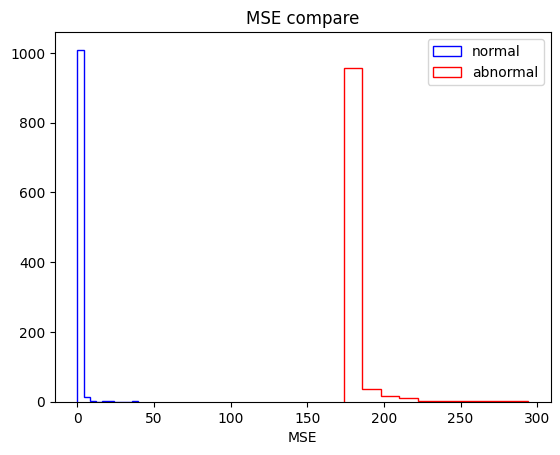

In [53]:
plt.title('MSE compare')
plt.hist(Nom_pred_mse, bins=10, color='blue', histtype='step', label='normal')
plt.hist(ANom_pred_mse, bins=10, color='red', histtype='step', label='abnormal')
plt.xlabel('MSE')
plt.legend()
plt.show()

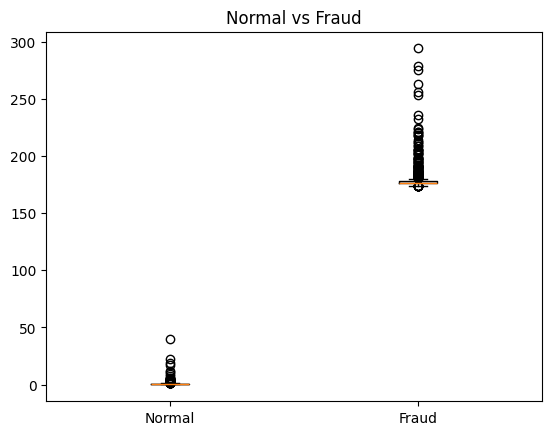

In [54]:
plt.boxplot([Nom_pred_mse, ANom_pred_mse])
plt.title('Normal vs Fraud')
plt.xticks(ticks=[1, 2], labels=['Normal', 'Fraud'])
plt.show()

### 잠재표현(Latent Representations) 시각화

In [41]:
X_test.shape

(625759, 7)

In [42]:
latent_x_mean, latent_x_std, latent_x  = encoder(X_test)

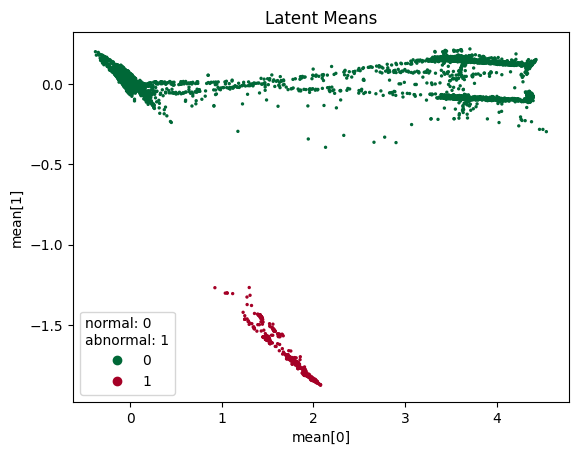

In [43]:
#  X_test의 잠재 공간에서의 평균을 산점도로 그립니다.
ax = plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=y_test, cmap='RdYlGn_r', s=2)

# 제목과 축 레이블을 설정합니다.
plt.title('Latent Means')
plt.xlabel('mean[0]')
plt.ylabel('mean[1]')

# 범례 추가: y_test 값에 따라 0은 Normal, 1은 Fraud로 표시합니다.
# 간단히 범례를 추가합니다.
plt.legend(*ax.legend_elements(), title="normal: 0\nabnormal: 1")

# 그래프를 표시합니다.
plt.show()

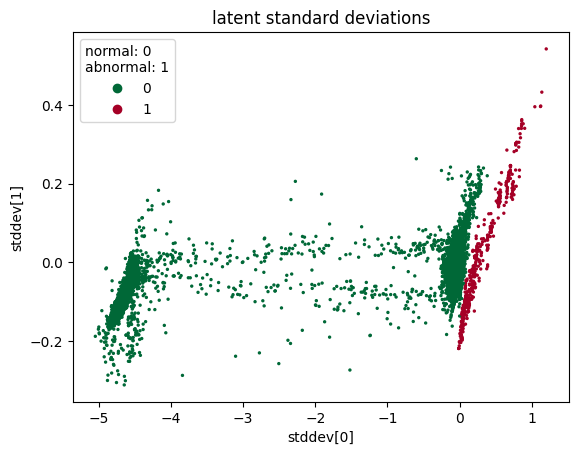

In [44]:
# X_test의 잠재 표현 표준 편차 계산
ax = plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.xlabel('stddev[0]')
plt.ylabel('stddev[1]')
plt.legend(*ax.legend_elements(), title="normal: 0\nabnormal: 1")
plt.show()

In [ ]:
# X_test의 잠재 표현 시각화
ax = plt.scatter(latent_x[:, 0], latent_x[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.legend(*ax.legend_elements(), title="normal: 0\nabnormal: 1")
plt.show()

### Reconstruction error threshold

In [ ]:
# VAE를 사용하여 train set의 데이터를 재구성(predictions)합니다.
predictions = vae.predict(X_train)

# 원본 데이터(X_train)와 재구성된 데이터(predictions) 간의 평균 제곱 오차(MSE)를 계산
# 각 샘플에 대해 MSE를 계산하여, 재구성 오류를 측정합니다.
mse = np.mean(np.power(X_train - predictions, 2), axis=1)

# 재구성 오류(mse)와 실제 클래스(y_train)를 포함한 데이터프레임을 생성
# 각 샘플의 재구성 오류와 해당 샘플이 정상(0)인지 사기(1)인지 나타내는 레이블을 포함
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})

error_df.head()

In [ ]:
# 'true_class' 값에 따라 정상(0)과 사기(1) 데이터로 그룹한 다음, 각 그룹의 재구성 오류에 대한 기술 통계를 구합니다.
desc = error_df.groupby('true_class').describe()
desc

In [ ]:
# 정상 클래스(true_class가 0인 데이터)의 재구성 오류에 대한 평균(mean)과 표준 편차(std)를 추출
# desc 데이터프레임에서 'reconstruction_error' 열의 평균과 표준 편차를 가져옵니다.
mean = desc['reconstruction_error']['mean'][0]   # 정상 데이터의 재구성 오류 평균
std = desc['reconstruction_error']['std'][0]            # 정상 데이터의 재구성 오류 표준 편차

# 다양한 임계값(thresholds) 설정. 임계값은 3-sigma, 2.5-sigma, 2-sigma로 설정.
thresholds = {'3sigma': mean + 3*std,
              '2.5sigma': mean + 2.5*std,
              "2sigma": mean + 2*std}

# 계산된 평균, 표준 편차, 그리고 임계값들을 출력
mean, std, thresholds

19555/19555 [==============================] - 28s 1ms/step
Precision 0.03
Recall 1.00


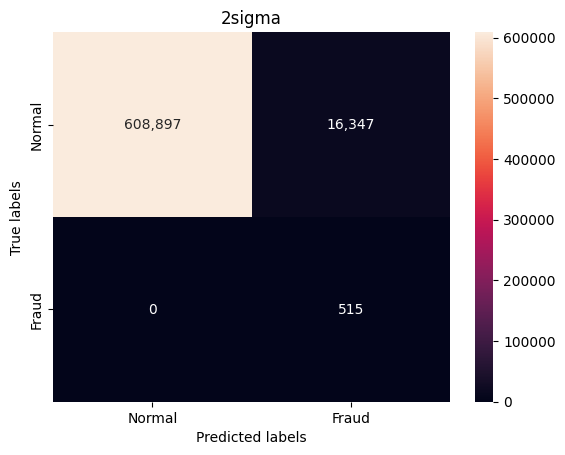

19555/19555 [==============================] - 28s 1ms/step
Precision 0.06
Recall 1.00


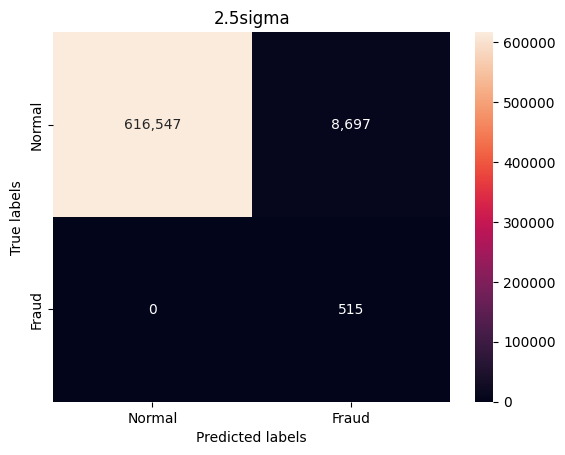

19555/19555 [==============================] - 28s 1ms/step
Precision 0.08
Recall 1.00


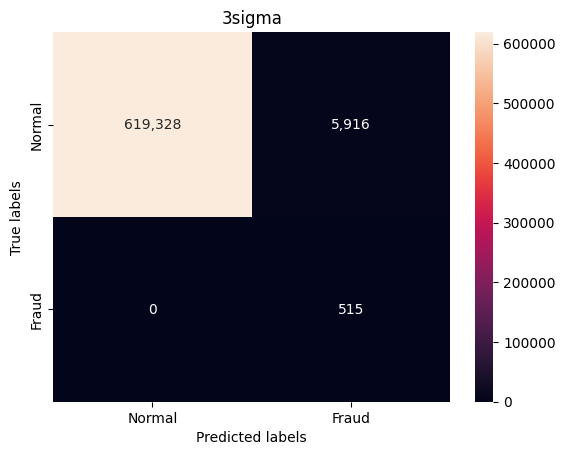

In [49]:
# thresholds 딕셔너리를 value 값 기준으로 오름차순 정렬합니다.
thresholds = sorted(thresholds.items(), key=lambda kv: kv[1])

# 모델의 예측을 수행하는 함수입니다.
# 주어진 임계값(threshold)과 MSE(Mean Squared Error)를 비교하여
# 예측 결과를 반환합니다. MSE가 임계값보다 크면 1(사기), 작으면 0(정상)으로 예측합니다.
def model_predict(threshold, mse):
    predictions = [(lambda er: 1 if er > threshold else 0)(er) for er in mse]
    return predictions

# 각 sigma와 그에 대응하는 threshold 값을 기준으로 모델을 평가합니다.
for sigma, threshold in thresholds:

    # VAE를 사용해 X_test 데이터에 대한 예측을 수행합니다.
    test_predictions = vae.predict(X_test)

    # MSE(Mean Squared Error)를 계산합니다.
    # 각 테스트 샘플에 대해 원본 데이터와 예측 데이터 간의 제곱 오차 평균을 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # 임계값을 사용해 예측 결과를 0 또는 1로 변환합니다.
    y_pred = model_predict(threshold, mse)

    # 정밀도(Precision)와 재현율(Recall)을 계산하고 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬(Confusion Matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')  # x축 레이블 설정
    ax.set_ylabel('True labels')       # y축 레이블 설정
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블 설정
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블 설정
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치 설정
    ax.set_title(sigma)  # 히트맵의 제목을 sigma 값으로 설정
    plt.show()  # 히트맵을 표시